<a href="https://colab.research.google.com/github/akarshp28/Applied-Inverse-Problems-Course/blob/main/akarsh_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle as pl
from PIL import Image
import glob
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision
from torchvision import transforms

## check if GPU is available and use it otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/MyDrive/Spring 2022/Inverse Problems/hw1/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


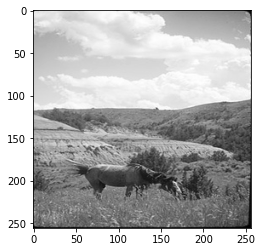

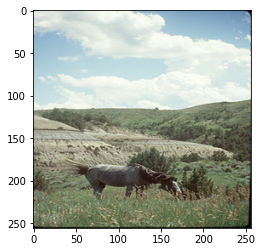

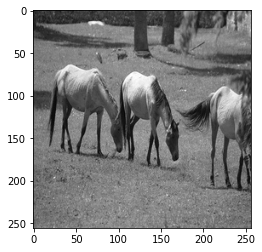

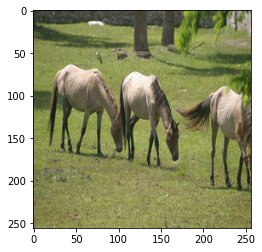

In [2]:
# Load Data
image_Names = glob.glob('/content/gdrive/MyDrive/Spring 2022/Inverse Problems/hw1/Train_RGB/*')
x_BW = torch.zeros((len(image_Names),1,256,256))
y_RGB = torch.zeros((len(image_Names),3,256,256))
for i in range(len(image_Names)):
    image = Image.open(image_Names[i])
    image_BW = torchvision.transforms.Grayscale()(image)
    y = TF.to_tensor(image)
    y.unsqueeze_(0)
    y_RGB[i,:,:,:] = y[:,:,:]
    x = TF.to_tensor(image_BW)
    x.unsqueeze_(0)
    x_BW[i,:,:,:] = x[:,:,:]

# Visualize some data
for i in range(2):
    plt.figure(i*2+1)
    plt.imshow(x_BW[i].transpose(0,2).transpose(0,1)[:,:, 0], cmap='gray')
    plt.show
    plt.figure(i*2)
    plt.imshow(y_RGB[i].transpose(0,2).transpose(0,1))
    plt.show

In [3]:
class BWtoRGB(nn.Module):
    def __init__(self):
        super(BWtoRGB, self).__init__()
        
        #****************** 2.a Start Here   *******************#
        self.conv1 = nn.Conv2d(1, 20, 5, padding=(2, 2))
        self.conv2 = nn.Conv2d(20, 20, 5, padding=(2, 2))
        self.conv3 = nn.Conv2d(20, 3, 5, padding=(2, 2))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
        
        #****************** 2.a End Here   *******************#
    
net = BWtoRGB()

#* Check if you answer passes some tests ****************#
#* This does not imply that the answer is correct *******#

out = net(x_BW[0:1])
print('Your network output dimension =',out.shape)
print('True network output dimension = torch.Size([1, 3, 256, 256])')

Your network output dimension = torch.Size([1, 3, 256, 256])
True network output dimension = torch.Size([1, 3, 256, 256])


In [4]:
# Train Neural Network

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lossMSE = nn.MSELoss()

epochs = 50
batch_size = 8

for epoch in range(epochs):
    shuffle_index = np.random.permutation(len(image_Names))
    losses = 0
    for i in range(int(len(image_Names)/batch_size)):
        net.zero_grad()
        batch_BW = x_BW[i*batch_size:(i+1)*batch_size,:,:,:]
        target_batch_RGB = y_RGB[i*batch_size:(i+1)*batch_size,:,:,:]
        
        #****************** 2.b Start Here   *******************#
        output = net(batch_BW)
        loss = lossMSE(output, target_batch_RGB)

        optimizer.zero_grad()
        optimizer.step(loss.backward())
        
        #****************** 2.b End Here   *******************#
        
        losses = loss.data.numpy() + losses
    print('Epoch =', epoch,' MSE =',losses/float(int(len(image_Names)/batch_size)))
    
print('At Epoch=50 your MSE is expected to be smaller 0.001.')

Epoch = 0  MSE = 0.2910013794898987
Epoch = 1  MSE = 0.19302517175674438
Epoch = 2  MSE = 0.0764776673167944
Epoch = 3  MSE = 0.04940452612936497
Epoch = 4  MSE = 0.05221979692578316
Epoch = 5  MSE = 0.024818013422191143
Epoch = 6  MSE = 0.022956181317567825
Epoch = 7  MSE = 0.031851681880652905
Epoch = 8  MSE = 0.030188705772161484
Epoch = 9  MSE = 0.02085685357451439
Epoch = 10  MSE = 0.01625463366508484
Epoch = 11  MSE = 0.01870136149227619
Epoch = 12  MSE = 0.017498335801064968
Epoch = 13  MSE = 0.015542287845164537
Epoch = 14  MSE = 0.016010955441743135
Epoch = 15  MSE = 0.015285191591829062
Epoch = 16  MSE = 0.012936483602970839
Epoch = 17  MSE = 0.012834921479225159
Epoch = 18  MSE = 0.01302427425980568
Epoch = 19  MSE = 0.011975234374403954
Epoch = 20  MSE = 0.012096569873392582
Epoch = 21  MSE = 0.011132590938359499
Epoch = 22  MSE = 0.010833438020199537
Epoch = 23  MSE = 0.010113716591149569
Epoch = 24  MSE = 0.010118719190359116
Epoch = 25  MSE = 0.009566852822899818
Epoch =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


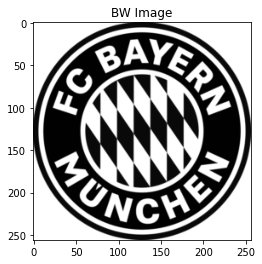

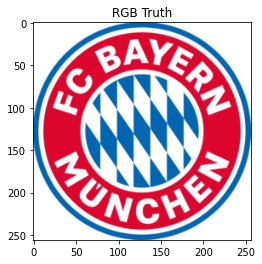

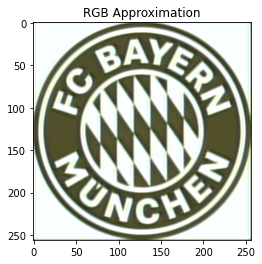

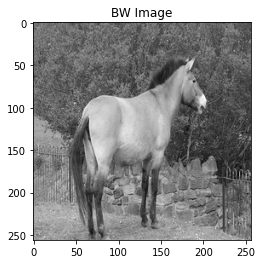

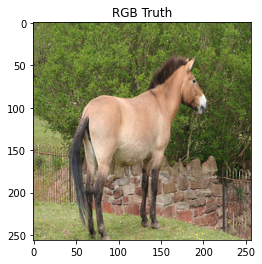

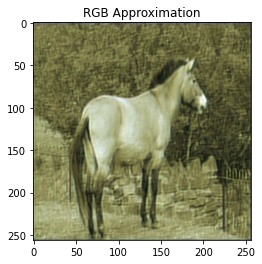

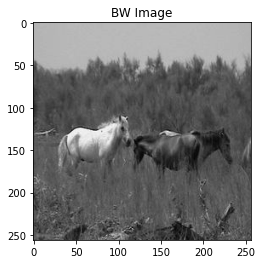

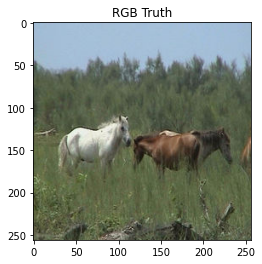

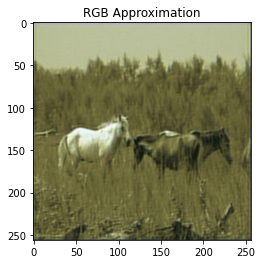

In [5]:
# Load Test Data
image_Names_test = glob.glob('/content/gdrive/MyDrive/Spring 2022/Inverse Problems/hw1/Test_RGB/*')
x_BW_test = torch.zeros((len(image_Names_test),1,256,256))
y_RGB_test = torch.zeros((len(image_Names_test),3,256,256))
for i in range(len(image_Names_test)):
    image_test = Image.open(image_Names_test[i])
    
    ################# New addition #############
    
    if TF.to_tensor(image_test).shape != x_BW_test.shape:
      image_test = TF.resize(image_test, [256])

    ################# New addition #############

    image_BW_test = torchvision.transforms.Grayscale()(image_test)
    y_test = TF.to_tensor(image_test)
    y_test.unsqueeze_(0)
    y_RGB_test[i,:,:,:] = y_test[:,:,:]
    x_test = TF.to_tensor(image_BW_test)
    x.unsqueeze_(0)
    x_BW_test[i,:,:,:] = x_test[:,:,:]
    
# Solve Inverse Problem on Test Data
InverseAproxRGB = net(x_BW_test)

# Visualize Inverse Problems
for i in range(3):
    plt.figure(i*3)
    plt.imshow(x_BW_test[i].transpose(0,2).transpose(0,1)[:,:,0], cmap='gray')
    plt.title('BW Image')
    plt.show
    plt.figure(i*3+1)
    plt.imshow(y_RGB_test[i].transpose(0,2).transpose(0,1))
    plt.title('RGB Truth')
    plt.show
    plt.figure(i*3+2)
    plt.imshow(InverseAproxRGB[i].transpose(0,2).transpose(0,1).detach().numpy())
    plt.title('RGB Approximation')
    plt.show

# Answer 2.3

Code doesnt work for other image sizes because of the zero padding in each conv layer. We are resizing images specifically to output images of size 256 x 256 x 3 from the CNN. 

In order to make other size images work, we need to manually resize any image to our requirement and then make inference. As seen in the above example, I used a new picture which is of 1200 x 1200 and resized it to 256 x 256 to make it work.